Data input : Data image binary dari citra 0 (without_pesticide) dan 10 (with_pesticide) mg/l | 50 augmentasi/image

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [4]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
base_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")


In [6]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_names = os.listdir(train_dir)
print(train_names)

validation_names = os.listdir(validation_dir)
print(validation_names)

test_names = os.listdir(test_dir)
print(test_names)


['with_pesticide', 'without_pesticide']
['with_pesticide', 'without_pesticide']
['with_pesticide', 'without_pesticide']


In [7]:
train_with_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/train/with_pesticide"
train_without_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/train/without_pesticide"

validation_with_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/validation/with_pesticide"
validation_without_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/validation/without_pesticide"

test_with_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/test/with_pesticide"
test_without_pesticide_dir = "/content/drive/MyDrive/Percobaan 2/TANPA ROI/Dataset/test/without_pesticide"


Samples from train_with_pesticide_dir:


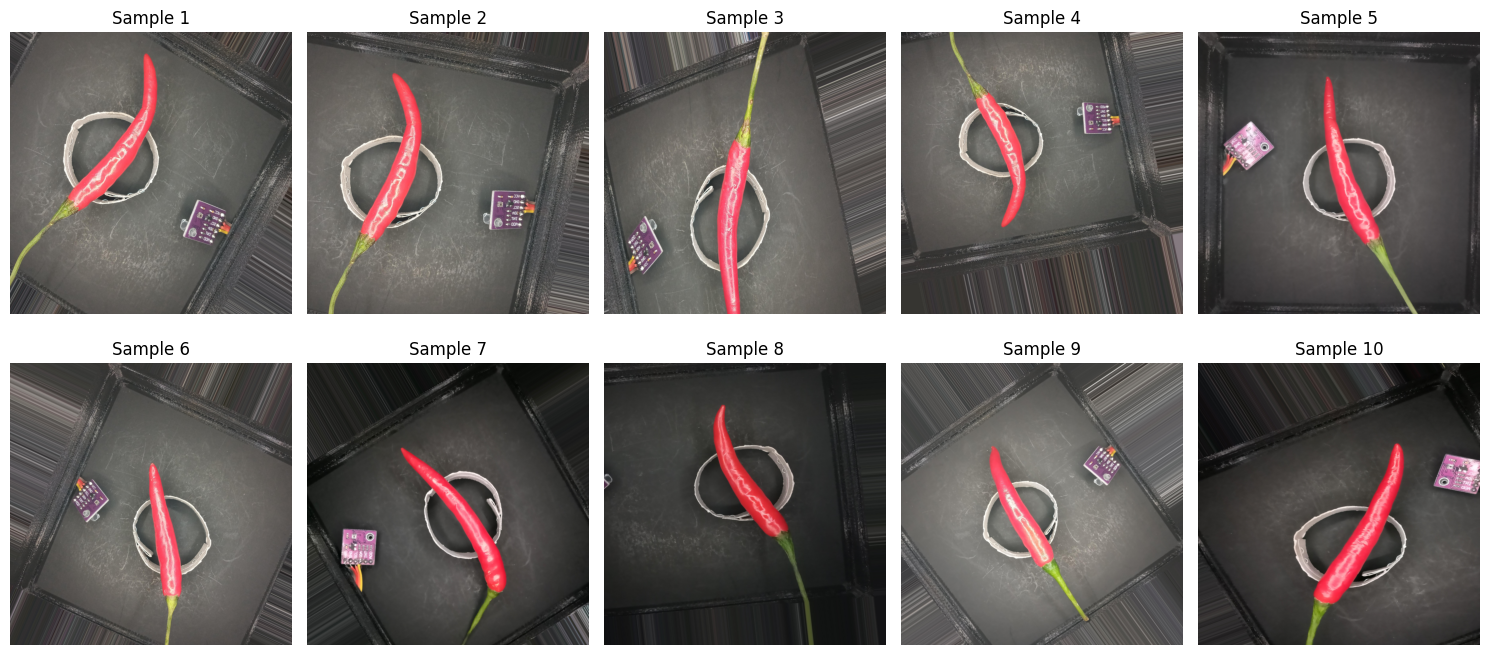

Samples from train_without_pesticide_dir:


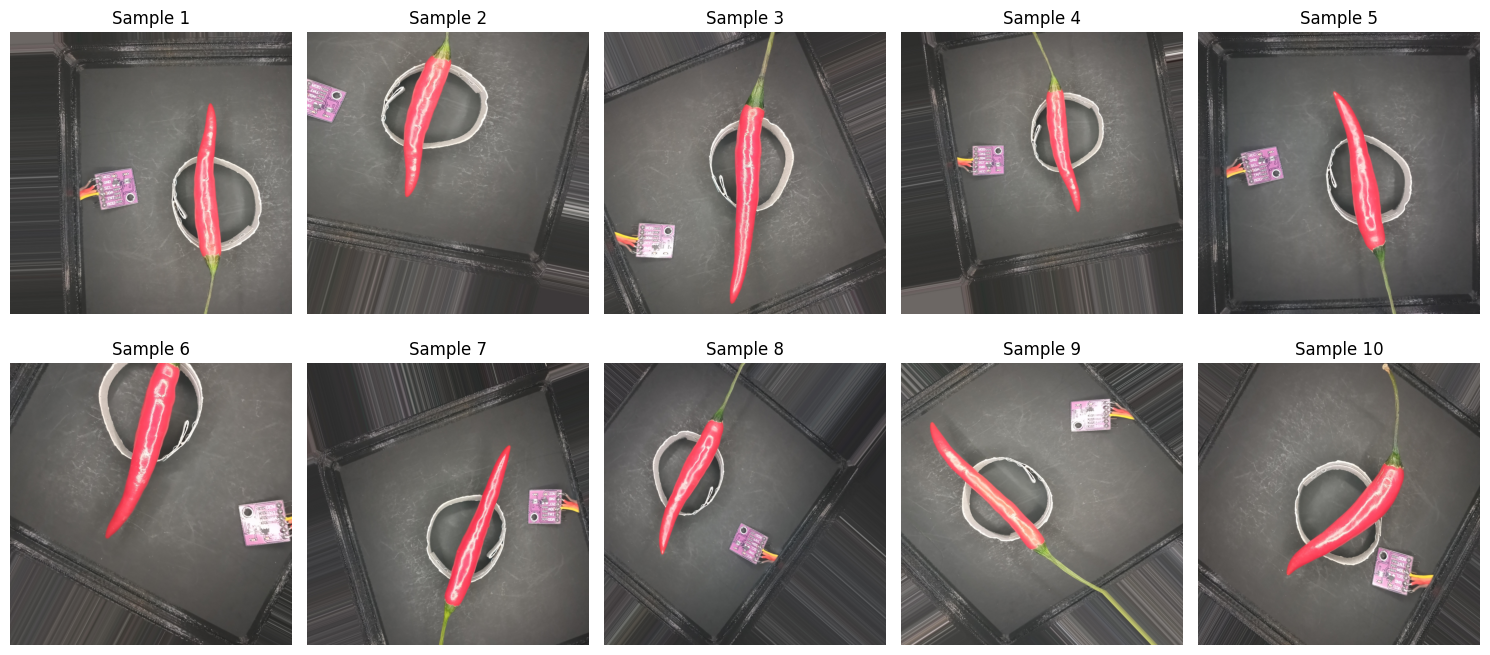

Samples from validation_with_pesticide_dir:


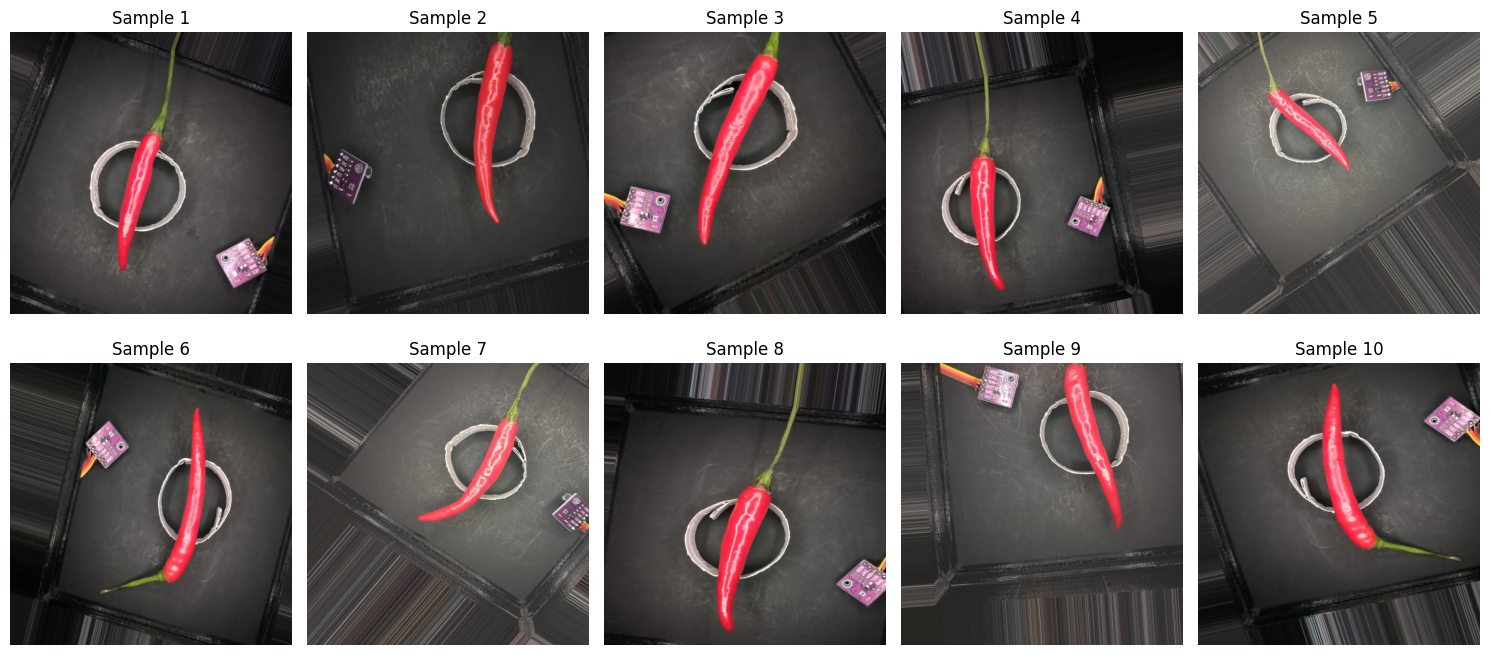

Samples from validation_without_pesticide_dir:


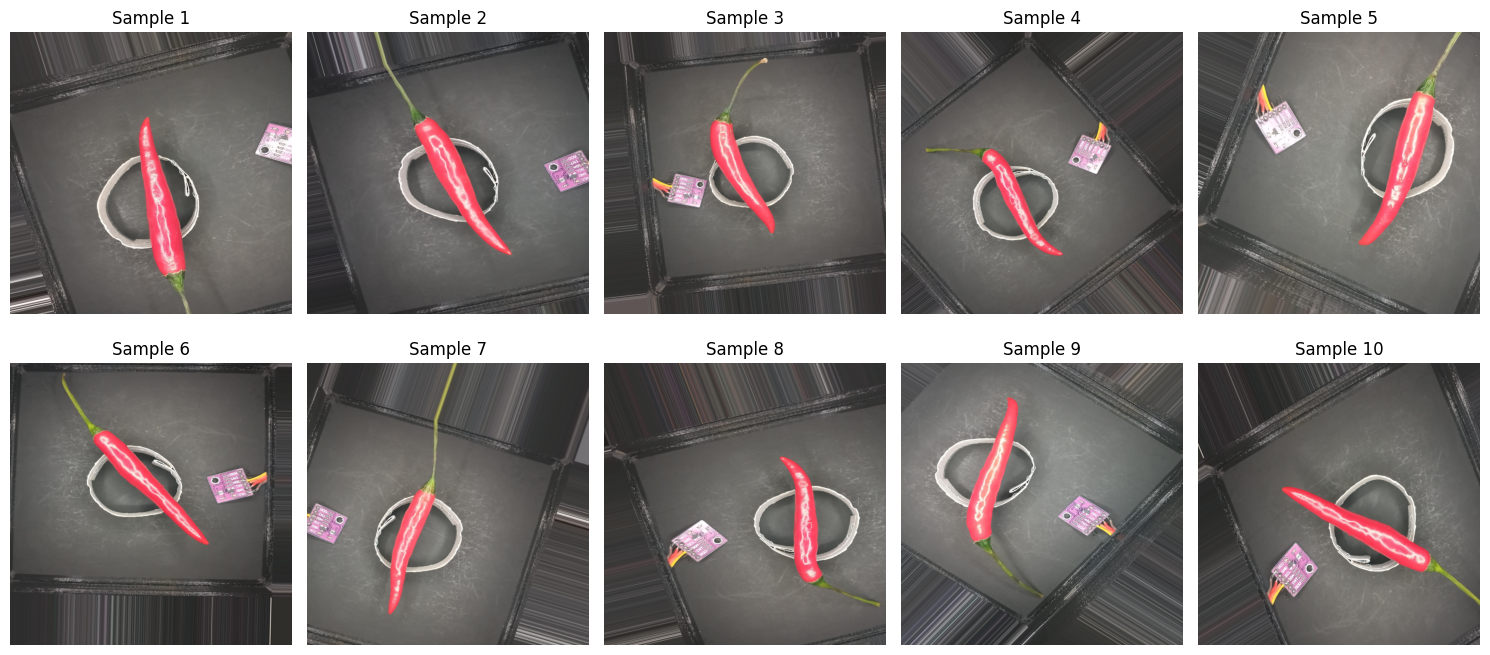

Samples from test_with_pesticide_dir:


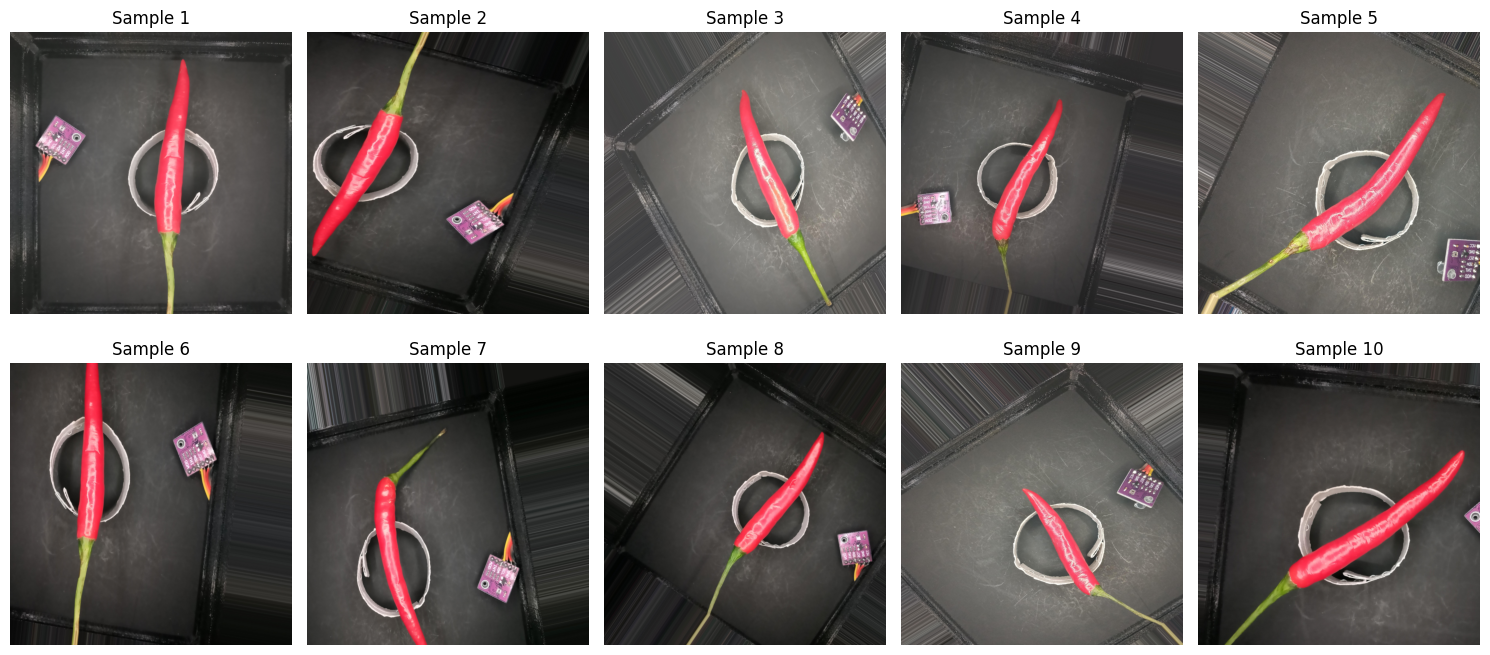

Samples from test_without_pesticide_dir:


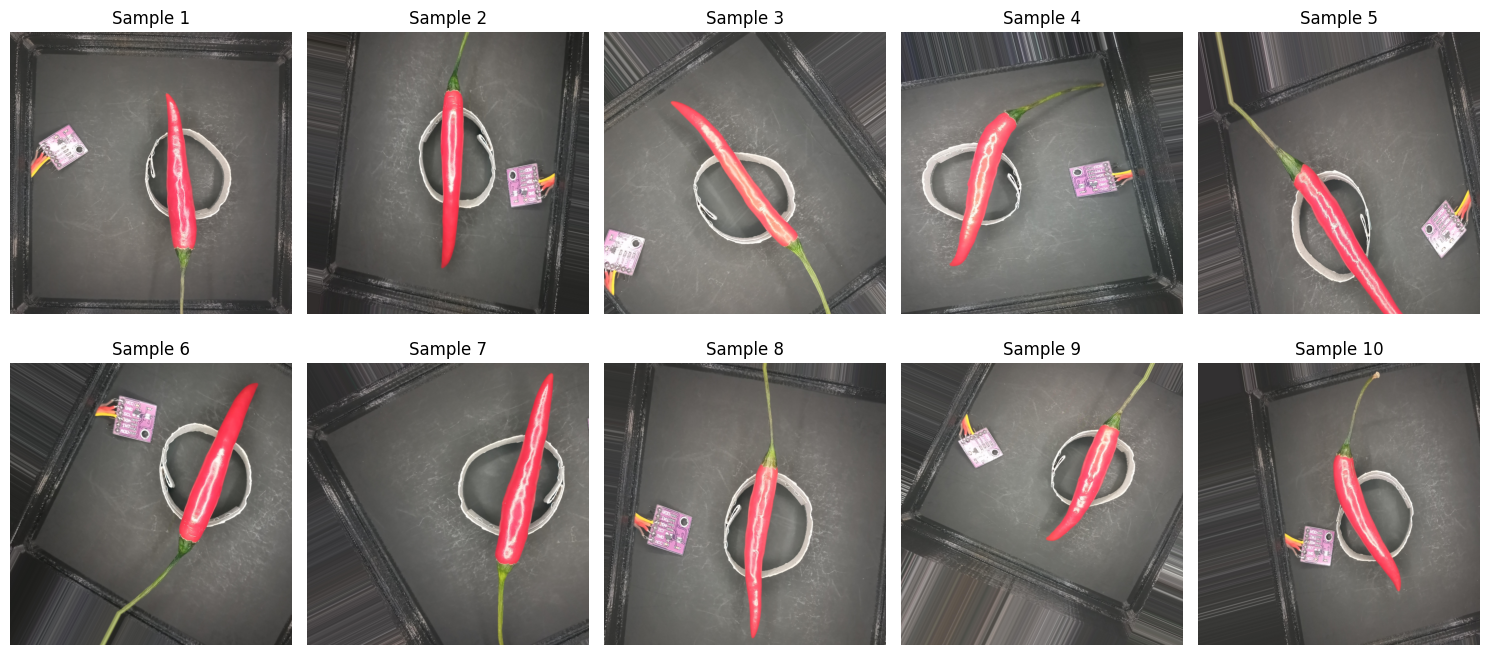

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_sample_images(directory, num_samples=10):
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 7))
    for idx, filename in enumerate(os.listdir(directory)[:num_samples]):
        img = mpimg.imread(os.path.join(directory, filename))
        if idx < num_samples//2:
            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f"Sample {idx+1}")
            axes[0, idx].axis('off')
        else:
            axes[1, idx - num_samples//2].imshow(img)
            axes[1, idx - num_samples//2].set_title(f"Sample {idx+1}")
            axes[1, idx - num_samples//2].axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from each directory
print("Samples from train_with_pesticide_dir:")
display_sample_images(train_with_pesticide_dir)

print("Samples from train_without_pesticide_dir:")
display_sample_images(train_without_pesticide_dir)

print("Samples from validation_with_pesticide_dir:")
display_sample_images(validation_with_pesticide_dir)

print("Samples from validation_without_pesticide_dir:")
display_sample_images(validation_without_pesticide_dir)

print("Samples from test_with_pesticide_dir:")
display_sample_images(test_with_pesticide_dir)

print("Samples from test_without_pesticide_dir:")
display_sample_images(test_without_pesticide_dir)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255)

validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                            target_size = (28, 28),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode= 'rgb',
                                            shuffle= True)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                             target_size = (28, 28),
                                             batch_size = 16,
                                             class_mode = 'categorical',
                                             color_mode = 'rgb',
                                             shuffle = True)

Found 612 images belonging to 2 classes.
Found 458 images belonging to 2 classes.


In [9]:
class_pesticide_dict = train_generator.class_indices
classes_pesticide = list(class_pesticide_dict.keys())
number_of_classes=len(classes_pesticide)

print ("List Classes of Pesticide:", classes_pesticide)
print ("Class Dictionary of Pesticide :", class_pesticide_dict)
print ("Total of Pesticide Classes :", number_of_classes)

List Classes of Pesticide: ['with_pesticide', 'without_pesticide']
Class Dictionary of Pesticide : {'with_pesticide': 0, 'without_pesticide': 1}
Total of Pesticide Classes : 2


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_sequential_model(input_shape=(28, 28, 3)):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])
    return model

# Create the model
model = create_sequential_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                   

In [11]:
from tensorflow.keras.optimizers import RMSprop

# Compile the model with specified learning rate
optimizer = Adam(learning_rate=0.0001)  # Adjust the learning rate as needed
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95):
            print("\nAccuracy has reached > 90%!")
            self.model.stop_training = True
callbacks = myCallback()

In [13]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])


Epoch 1/20
39/39 [==============================] - 68s 2s/step - loss: 0.6876 - accuracy: 0.5180 - val_loss: 0.6639 - val_accuracy: 0.6223
Epoch 2/20
39/39 [==============================] - 63s 2s/step - loss: 0.6082 - accuracy: 0.7157 - val_loss: 0.5771 - val_accuracy: 0.7511
Epoch 3/20
39/39 [==============================] - 67s 2s/step - loss: 0.4908 - accuracy: 0.7794 - val_loss: 0.4439 - val_accuracy: 0.7904
Epoch 4/20
39/39 [==============================] - 65s 2s/step - loss: 0.4488 - accuracy: 0.7958 - val_loss: 0.5227 - val_accuracy: 0.7555
Epoch 5/20
39/39 [==============================] - 63s 2s/step - loss: 0.4512 - accuracy: 0.7680 - val_loss: 0.4138 - val_accuracy: 0.8100
Epoch 6/20
39/39 [==============================] - 63s 2s/step - loss: 0.4140 - accuracy: 0.8105 - val_loss: 0.4119 - val_accuracy: 0.8057
Epoch 7/20
39/39 [==============================] - 63s 2s/step - loss: 0.3939 - accuracy: 0.8317 - val_loss: 0.4011 - val_accuracy: 0.8166
Epoch 8/20
39/39 [==

In [14]:
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.1871642768383026
Train Accuracy: 0.923202633857727


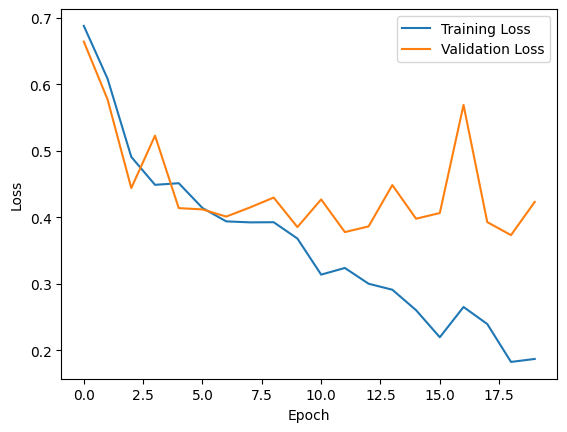

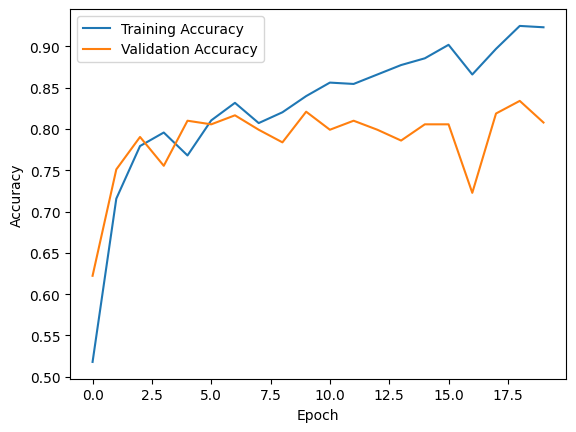

In [15]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 460 images belonging to 2 classes.
29/29 [==============================] - 25s 864ms/step


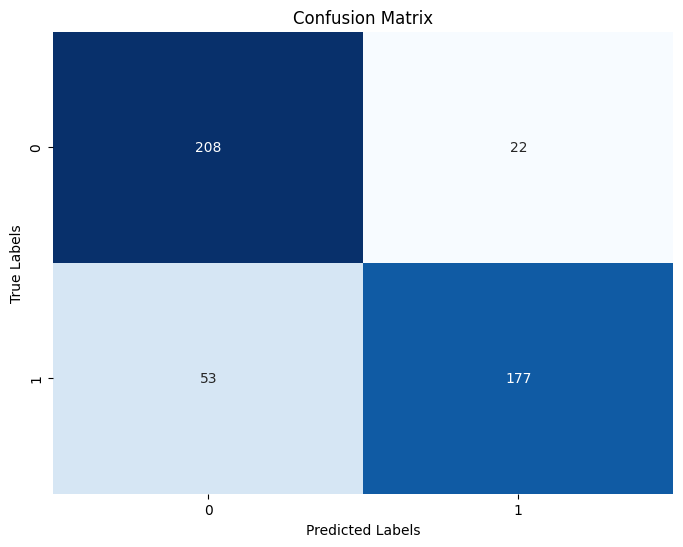

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       230
           1       0.89      0.77      0.83       230

    accuracy                           0.84       460
   macro avg       0.84      0.84      0.84       460
weighted avg       0.84      0.84      0.84       460



In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(28, 28),
                                                  batch_size=16,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=False)

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_true, y_pred)

# Print classification report
print("Classification Report:\n", class_report)


In [17]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Percobaan 2/Model/model.h5'

# Save the trained model
model.save(save_path)
print("Model saved at:", save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at: /content/drive/MyDrive/Percobaan 2/Model/model.h5
